# Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».  

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.  

Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.  

## Инструкция по выполнению проекта

    1. Откройте файл с данными и изучите его. Путь к файлу: users_behavior.csv.
    2. Разделите исходные данные на обучающую, валидационную и тестовую выборки.
    3. Исследуйте качество разных моделей, меняя гиперпараметры. Кратко напишите выводы исследования.
    4. Проверьте качество модели на тестовой выборке.
    5. Дополнительное задание: проверьте модели на вменяемость. Ничего страшного, если не получится: эти данные сложнее тех, с которыми вы работали раньше. В следующем курсе подробнее об этом расскажем.

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

    - сalls — количество звонков,
    - minutes — суммарная длительность звонков в минутах,
    - messages — количество sms-сообщений,
    - mb_used — израсходованный интернет-трафик в Мб,
    - is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

### Libs

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Откройте файл с данными и изучите его. Путь к файлу: users_behavior.csv.

In [20]:
df = pd.read_csv('users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


#### Изменим тип колонки messages на int, т.к нецелового числа сообщений не может быть.

In [22]:
df['messages'] = df['messages'].astype('int')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int32  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(3), int32(1), int64(1)
memory usage: 113.1 KB


In [24]:
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83,19915.42,0
1,85.0,516.75,56,22696.96,0
2,77.0,467.66,86,21060.45,0
3,106.0,745.53,81,8437.39,1
4,66.0,418.74,1,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20,35124.90,1
3210,25.0,190.36,0,3275.61,0
3211,97.0,634.44,70,13974.06,0
3212,64.0,462.32,90,31239.78,0


#### Пропуски отсутсвуют. Дополнптельных действий по предобработке данных не требуется, все переменные количественные. Необходимо решить задачу бинарной классификации.

#### Проверим мультиколлинеарность факторов 

In [25]:
corr = df.corr()
corr

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


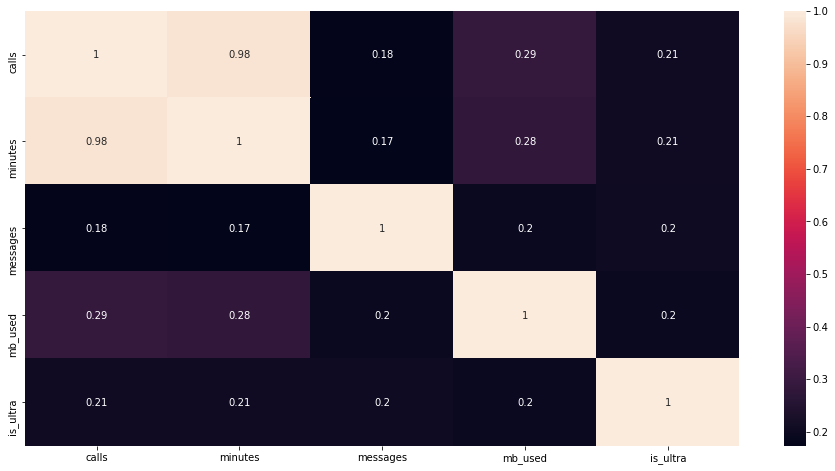

In [26]:
plt.figure(figsize=(16, 8))
sns.heatmap(corr, annot=True);

#### Наблюдается сильная связь между количеством и продолжительностью звонков. Чтобы избежать переобучения уберем из дата сета колонку calls.

In [27]:
df = df.drop(['calls'], axis=1)

In [28]:
df.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83,19915.42,0
1,516.75,56,22696.96,0
2,467.66,86,21060.45,0
3,745.53,81,8437.39,1
4,418.74,1,14502.75,0


#### 2. Разделите исходные данные на обучающую, валидационную и тестовую выборки.

In [29]:
features = df.drop('is_ultra', axis=1)
features

,minutes,messages,mb_used
0,311.90,83,19915.42
1,516.75,56,22696.96
2,467.66,86,21060.45
3,745.53,81,8437.39
4,418.74,1,14502.75
...,...,...,...
3209,910.98,20,35124.90
3210,190.36,0,3275.61
3211,634.44,70,13974.06
3212,462.32,90,31239.78


In [30]:
target = df['is_ultra']
target

0       0
1       0
2       0
3       1
4       0
       ..
3209    1
3210    0
3211    0
3212    0
3213    1
Name: is_ultra, Length: 3214, dtype: int64

In [31]:
features_train, features_test, target_train, target_test  = train_test_split(features, target, test_size=0.2, random_state=42)
features_val, features_test, target_val, target_test = train_test_split(features_test, target_test, test_size=0.25, random_state=42)

#### Проверим корректность разбиения данных

In [33]:
print(features_train.shape)
print(features_test.shape)
print(features_val.shape)
print('Сумма =', features_train.shape[0] + features_val.shape[0] + features_test.shape[0])

print('Тренировочные данные', (np.ceil(features_train.shape[0] / features.shape[0] * 100)), '%')

print('Валидационные данные', (np.ceil(features_val.shape[0] / features.shape[0] * 100)), '%')

print('Тестовые данные', (round(features_test.shape[0] / features.shape[0] * 100)), '%')

(2571, 3)
(161, 3)
(482, 3)
Сумма = 3214
Тренировочные данные 80.0 %
Валидационные данные 15.0 %
Тестовые данные 5 %


#### Напишим функцию для выбора модели классификации, без изменения гиперпараметров

In [34]:
def get_best_model(model):
    model = model(random_state=12345)
    model.fit(features_train, target_train)
    predict = model.predict(features_val)
    accuracy = accuracy_score(predict, target_val)
    print(f'Модель - {model}, Точность = {accuracy}')

In [35]:
get_best_model(DecisionTreeClassifier)
get_best_model(RandomForestClassifier)
get_best_model(LogisticRegression)

Модель - DecisionTreeClassifier(random_state=12345), Точность = 0.7468879668049793
Модель - RandomForestClassifier(random_state=12345), Точность = 0.8298755186721992
Модель - LogisticRegression(random_state=12345), Точность = 0.7178423236514523


#### Выберем самую точную модель и на ней будем мнастривать гиперпараметры

### 3. Исследуйте качество разных моделей, меняя гиперпараметры. Кратко напишите выводы исследования.

In [36]:
best_model_rf = None
best_result_rf = 0
best_est_rf = 0
best_depth_rf = 0

for est in range(1, 51, 10):
    for depth in range(1, 11): 
        rf_model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=12345)
        rf_model.fit(features_train, target_train)
        predict_val = rf_model.predict(features_val)
        accuracy = accuracy_score(predict_val, target_val)
        if accuracy > best_result_rf:
            best_result_rf = rf_model
            best_result_rf = accuracy
            best_est_rf = est
            best_depth_rf = depth
            print(f'Максимальная глубина = {best_depth_rf}, Количество деревьев ={best_est_rf}, Accuracy = {best_result_rf}')

Максимальная глубина = 1, Количество деревьев =1, Accuracy = 0.7406639004149378
Максимальная глубина = 2, Количество деревьев =1, Accuracy = 0.7676348547717843
Максимальная глубина = 5, Количество деревьев =1, Accuracy = 0.7883817427385892
Максимальная глубина = 7, Количество деревьев =1, Accuracy = 0.7946058091286307
Максимальная глубина = 5, Количество деревьев =11, Accuracy = 0.8132780082987552
Максимальная глубина = 6, Количество деревьев =11, Accuracy = 0.8153526970954357
Максимальная глубина = 10, Количество деревьев =11, Accuracy = 0.8195020746887967
Максимальная глубина = 6, Количество деревьев =21, Accuracy = 0.8215767634854771
Максимальная глубина = 8, Количество деревьев =31, Accuracy = 0.8278008298755186


#### Маскимальная точность (Accuracy = 0.8278008298755186) достигается при следующих параметрах: Максимальная глубина = 8, Количество деревьев = 31

#### Проверим на других моделях.

#### DecisionTreeClassifier

In [37]:
best_result_dt = 0
best_depth_dt = 0

for depth in range(1, 11): 
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    dt_model.fit(features_train, target_train)
    predict_val = dt_model.predict(features_val)
    accuracy = accuracy_score(predict_val, target_val)
    if accuracy > best_result_dt:
        best_result_dt = accuracy
        best_depth_dt = depth
        print(f'Максимальная глубина = {best_depth_dt}, Accuracy = {best_result_dt}')

Максимальная глубина = 1, Accuracy = 0.7531120331950207
Максимальная глубина = 2, Accuracy = 0.8029045643153527
Максимальная глубина = 3, Accuracy = 0.8112033195020747
Максимальная глубина = 4, Accuracy = 0.8132780082987552
Максимальная глубина = 5, Accuracy = 0.8174273858921162
Максимальная глубина = 7, Accuracy = 0.8195020746887967
Максимальная глубина = 8, Accuracy = 0.8215767634854771


#### Маскимальная точность (Accuracy = 0.8215767634854771) достигается при максимальной глубине = 8

#### LogisticRegression

In [38]:
lr = LogisticRegression(random_state=12345)
lr.fit(features_train, target_train)
lr_predictions = lr.predict(features_val)
lr_accuracy = accuracy_score(lr_predictions, target_val)
print('Точность логистической регресии:', lr_accuracy)

Точность логистической регресии: 0.7178423236514523


### Вывод: Лучшей моделью по метрике accuracy признана RandomForestClassifier. Маскимальная точность (Accuracy = 0.8278008298755186) достигается при следующих параметрах: Максимальная глубина = 8, Количество деревьев = 31

# 4. Проверьте качество модели на тестовой выборке.

In [39]:
rf_model.fit(features_train, target_train)
rf_predict = rf_model.predict(features_test)
accuracy_rf = accuracy_score(rf_predict, target_test)
print("Accuracy на лучшей модели RandomForestClassifier на тестовой выборке: ", accuracy_rf)

Accuracy на лучшей модели RandomForestClassifier на тестовой выборке:  0.7888198757763976


### Качество модели ухудшилось, вероятно из-за меньшей выборки данных

#### Попробуем обучить на двух выборках и проверить результать accuracy

In [40]:
rf_model.fit(features_train, target_train)
rf_model.fit(features_val, target_val)
rf_predict = rf_model.predict(features_test)
accuracy_rf = accuracy_score(rf_predict, target_test)
print("Accuracy на лучшей модели RandomForestClassifier на тестовой выборке: ", accuracy_rf)

Accuracy на лучшей модели RandomForestClassifier на тестовой выборке:  0.8136645962732919


### Точность увеличилась.


# 5. Дополнительное задание: проверьте модели на вменяемость. Ничего страшного, если не получится: эти данные сложнее тех, с которыми вы работали раньше. В следующем курсе подробнее об этом расскажем.

#### C помощью DummyClassifier расcчитаем оценку точности без обучения модели.

In [41]:
from sklearn.dummy import DummyClassifier

In [42]:
clf = DummyClassifier(strategy = 'most_frequent', random_state = 12345)
clf.fit(features_train, target_train)
clf.score(features_test, target_test)

0.6956521739130435

#### Вывод: С имеющимися данными мы можем более индивидуально предлагать тарифы для клиентов, с учетом их расходов минут, сообщений, интернет-трафика. Если не использовать модель, то с точность `70% мы сможем выбрать правильный тариф, с моделью - свыше 80%.
#### Иными словами, используя модель мы сможем привлечь больше пользователей к определенному тарифу, чем без нее

#### Проверка 2

In [48]:
class_frequency = df['is_ultra'].value_counts(normalize=True)
class_frequency

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

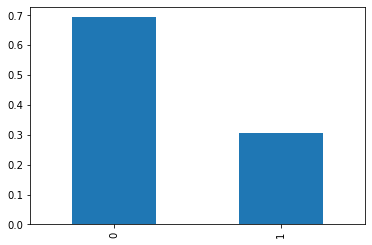

In [50]:
class_frequency.plot(kind='bar');

In [56]:
predicted_valid = pd.Series(rf_model.predict(features_test))

In [57]:
predicted_valid.value_counts(normalize=True)

0    0.795031
1    0.204969
dtype: float64

In [58]:
feature = df.drop('is_ultra', axis=1)

In [59]:
target1= df['is_ultra']

In [60]:
target_pred_constant = pd.Series(0, index=target1.index)

In [61]:
print(accuracy_score(target, target_pred_constant))

0.693528313627878


#### Качество на нашей модели выше, чем на константной модели, где всегда значение is_ultra = 0.

# Вывод:

В ходе использовались 3 модели:

- Дерево решений
- Случайный лес
- Логистическая регрессия  

1. Загрузили датасет и изучили данные: 4 анализируемых признака и 1 целевой, всего 3214 наблюдений.   
2. Выявили 2 мультиколлинеарных признака, которые могут негативно сказаться на качестве работы построения моделей. Убрали из исходного датасета колонку calls. Изменили тип признака message на целочисленный (int)
Выделили датасет с целевым признаком и датасет с анализируемыми признаками. Разделили их на 3 вырорки: обучающую, валидационную и тестовую. Соотношение выборок: 0.8:0.15:0.5   
3. Проверили качество моделей без гиперпараметров. Нашли самую точную - RandomForestClassifier. Подобрали гиперпараметры, рассчитали accuracy_score.  
4. Предсказали значения целевой переменной на валидационной, а затем и на тестовой выборке. На тестовой выборке рассчитали accuracy score. Подтвердили предположение этапа 3, что лучшая модель - RandomForestClassifier с параметрами Маскимальная точность (Accuracy = 0.8278008298755186) достигается при следующих параметрах: Максимальная глубина = 8, Количество деревьев = 3. На тестовой выборке заметили снижение accuracy_score. Решили выполнить обучение на 2-х выборках - валидационной и тренировочной. Качестов улучшилось. Вероятно снижение accuracy_score связано с маленькой выборкой данных в тестовом наборе (5%)  
5. Проверили модель на вменяемость с помощью модели DummyClassifier. В ходе проверки пришли к следующим выводам: С имеющимися данными мы можем более индивидуально предлагать тарифы для клиентов, с учетом их расходов минут, сообщений, интернет-трафика. Если не использовать модель, то с точность `70% мы сможем выбрать правильный тариф, с моделью - свыше 80%.
Иными словами, используя модель мы сможем привлечь больше пользователей к определенному тарифу, чем без нее